# setup

In [4]:
# is this the folder with the script in it?
scriptDir<-getwd()
scriptDir

# if not, uncomment and use this instead
# scriptDir<-""

[1] "/Users/jdh/SensorDataProcessing/rriv_methane/anya_methane"

In [5]:
methaneFunctions<-paste(scriptDir,"/methane_functions.r",sep="")
methaneFunctions
if (file.exists(methaneFunctions)){
    source(methaneFunctions)
} else {
    print("manually correct the location and/or name of methane_functions.r")
}

[1] "/Users/jdh/SensorDataProcessing/rriv_methane/anya_methane/methane_functions.r"

## import

In [6]:
# Package names
packages <- c("zoo","tidyverse","dplyr","plotly" ,"doBy", "lubridate", "ggplot2", "Hmisc", "zoo", "viridis", "gam", "ggeffects", "reshape2", "mgcv")
packageHandler(packages)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout



Attaching package: ‘doBy’


The follo

### Setting up working directory for data

In [7]:
datawd<-"/Users/jdh/Library/CloudStorage/GoogleDrive-jakehosen@gmail.com/My Drive/WaterBear/CH4 bucket data/"

### importing rriv calibration data from 7/24/2023
#### Starting with RRIV data

In [8]:
d20230724<-"/Users/jdh/Library/CloudStorage/GoogleDrive-jakehosen@gmail.com/My Drive/WaterBear/CH4 bucket data/20230724-outside/RRIV"
rriv_cal_20230724<-concat_dirs(d20230724, read_rriv_CSV, filePattern=".CSV", minFileSize=400)
rriv_cal_20230724<-process_rriv_columns(rriv_cal_20230724)
rriv_cal_20230724$Time<-rriv_cal_20230724$time.h

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”


[1] "Dataframe generated, manually process column types if necessary"


#### Now importing LGR data

In [9]:
lgr_20230724<-"/Users/jdh/Library/CloudStorage/GoogleDrive-jakehosen@gmail.com/My Drive/WaterBear/CH4 bucket data/20230724-outside/LGR/2023-07-24"
lgr_data_20230724<-concat_dirs(lgr_20230724, read_GA_ZIP, filePattern=".zip", minFileSize=300)
lgr_data_20230724$Time<-lubridate::as_datetime(lgr_data_20230724$Time)


[1] "Dataframe generated, manually process column types if necessary"


#### Creating a data frame with 1 minute intervals that spans the same date/time range as the RRIV calibration data.

In [10]:
rriv_assembly_df<-data.frame(Time=as.POSIXct(seq(as.numeric(range(rriv_cal_20230724$Time)[1]),as.numeric(range(rriv_cal_20230724$Time)[2]),by=60)))

#### Interpolating RRIV and LGR data to the new dataframe for Cal 1 and then removing hours without any data.

In [11]:
rriv_cal_20230724_cal1<-subset(rriv_cal_20230724,logger=="CAL1")
rriv_cal_20230724_cal1$hour<-hour(rriv_cal_20230724_cal1$Time)
rriv_cal_20230724_cal1$day<-day(rriv_cal_20230724_cal1$Time)


rriv_assembly_df$ch4_raw_int<-approx(rriv_cal_20230724_cal1$Time,rriv_cal_20230724_cal1$ch4_raw,xout=rriv_assembly_df$Time)$y
rriv_assembly_df$aht_RH_int<-approx(rriv_cal_20230724_cal1$Time,rriv_cal_20230724_cal1$aht_RH,xout=rriv_assembly_df$Time)$y
rriv_assembly_df$aht_C_int<-approx(rriv_cal_20230724_cal1$Time,rriv_cal_20230724_cal1$aht_C,xout=rriv_assembly_df$Time)$y

rriv_assembly_df$lgr_ch4<-approx(lgr_data_20230724$Time,lgr_data_20230724$X.CH4._ppm,xout=rriv_assembly_df$Time)$y
rriv_assembly_df$uuid<-unique(rriv_cal_20230724_cal1$uuid)

rriv_assembly_df$hour<-hour(rriv_assembly_df$Time)
rriv_assembly_df$day<-day(rriv_assembly_df$Time)


assembly_nogap_cal1<-merge(rriv_assembly_df,rriv_cal_20230724_cal1[,c("hour","day")],by=c("hour","day"))

In [12]:
rriv_cal_20230724_cal1<-subset(rriv_cal_20230724,logger=="CAL3")
rriv_cal_20230724_cal1$hour<-hour(rriv_cal_20230724_cal1$Time)
rriv_cal_20230724_cal1$day<-day(rriv_cal_20230724_cal1$Time)


rriv_assembly_df$ch4_raw_int<-approx(rriv_cal_20230724_cal1$Time,rriv_cal_20230724_cal1$ch4_raw,xout=rriv_assembly_df$Time)$y
rriv_assembly_df$aht_RH_int<-approx(rriv_cal_20230724_cal1$Time,rriv_cal_20230724_cal1$aht_RH,xout=rriv_assembly_df$Time)$y
rriv_assembly_df$aht_C_int<-approx(rriv_cal_20230724_cal1$Time,rriv_cal_20230724_cal1$aht_C,xout=rriv_assembly_df$Time)$y

rriv_assembly_df$lgr_ch4<-approx(lgr_data_20230724$Time,lgr_data_20230724$X.CH4._ppm,xout=rriv_assembly_df$Time)$y
rriv_assembly_df$uuid<-unique(rriv_cal_20230724_cal1$uuid)

rriv_assembly_df$hour<-hour(rriv_assembly_df$Time)
rriv_assembly_df$day<-day(rriv_assembly_df$Time)


assembly_nogap_cal3<-merge(rriv_assembly_df,rriv_cal_20230724_cal1[,c("hour","day")],by=c("hour","day"))

Warning message:
“Removed 5280 rows containing missing values (`geom_point()`).”


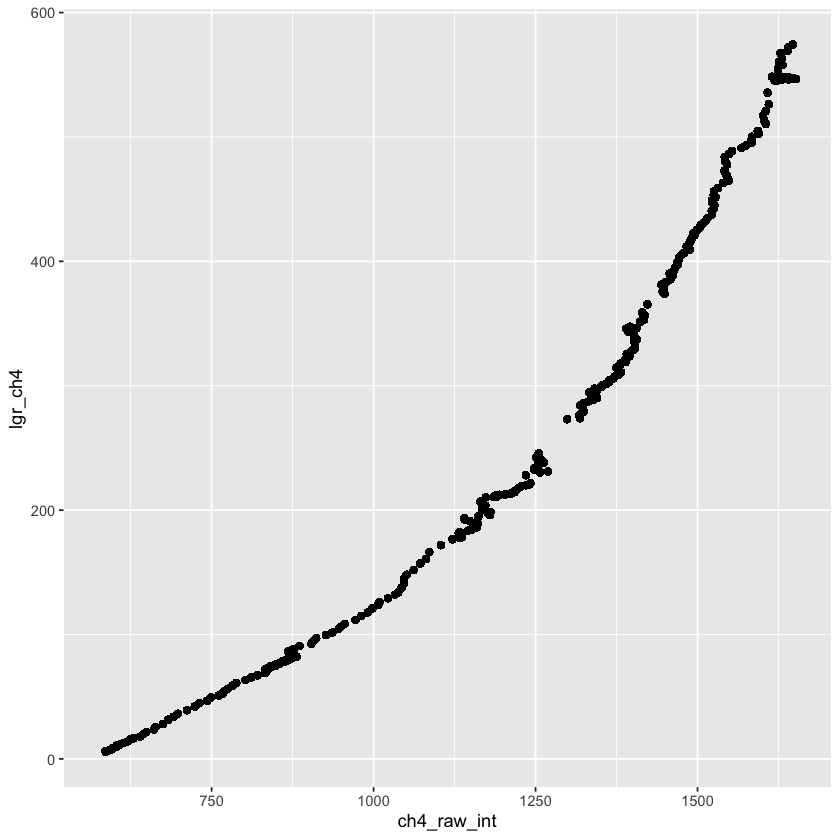

In [13]:
ggplot(assembly_nogap_cal3,aes(ch4_raw_int,lgr_ch4))+geom_point()

In [14]:
b3_exp_d<-"/Users/jdh/Library/CloudStorage/GoogleDrive-jakehosen@gmail.com/My Drive/WaterBear/CH4 bucket data/20230717/B3/WB"
b3_exp<-concat_dirs(b3_exp_d, read_rriv_CSV, filePattern=".CSV", minFileSize=400)
b3_exp<-process_rriv_columns(b3_exp)
b3_exp$Time<-b3_exp$time.h

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”


[1] "Dataframe generated, manually process column types if necessary"


[1] "type"        "site"        "logger"      "deployment"  "deployed_at"
 [6] "uuid"        "time.s"      "time.h"      "battery.V"   "aht_C"      
[11] "aht_RH"      "ch4_raw"     "ch4_cal"     "user_note"   "user_value" 
[16] "Time"

[1] "hour"        "day"         "Time"        "ch4_raw_int" "aht_RH_int" 
[6] "aht_C_int"   "lgr_ch4"     "uuid"

[1] 57FF6F068387575149330867
Levels: 57FF6F068387575149330867

[1] 57FF6F068387575149330867
4 Levels: 50FF6D068678545249232467 ... 57FF6F068387575149330867


Call:
lm(formula = lgr_ch4_log10 ~ ch4_raw_log10, data = assembly_nogap_cal3)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.48801 -0.02192 -0.00780  0.04682  0.10621 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -8.273942   0.004387   -1886   <2e-16 ***
ch4_raw_log10  3.438526   0.001431    2403   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07736 on 197998 degrees of freedom
  (5280 observations deleted due to missingness)
Multiple R-squared:  0.9668,	Adjusted R-squared:  0.9668 
F-statistic: 5.774e+06 on 1 and 197998 DF,  p-value: < 2.2e-16



Call:
lm(formula = lgr_ch4 ~ ch4_raw, data = assembly_nogap_cal3)

Residuals:
    Min      1Q  Median      3Q     Max 
-59.230 -34.874  -1.501  26.202  88.025 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.779e+02  3.509e-01   -1077   <2e-16 ***
ch4_raw      5.264e-01  2.834e-04    1857   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 38.32 on 197998 degrees of freedom
  (5280 observations deleted due to missingness)
Multiple R-squared:  0.9457,	Adjusted R-squared:  0.9457 
F-statistic: 3.45e+06 on 1 and 197998 DF,  p-value: < 2.2e-16


Warning message:
“Removed 5280 rows containing missing values (`geom_point()`).”


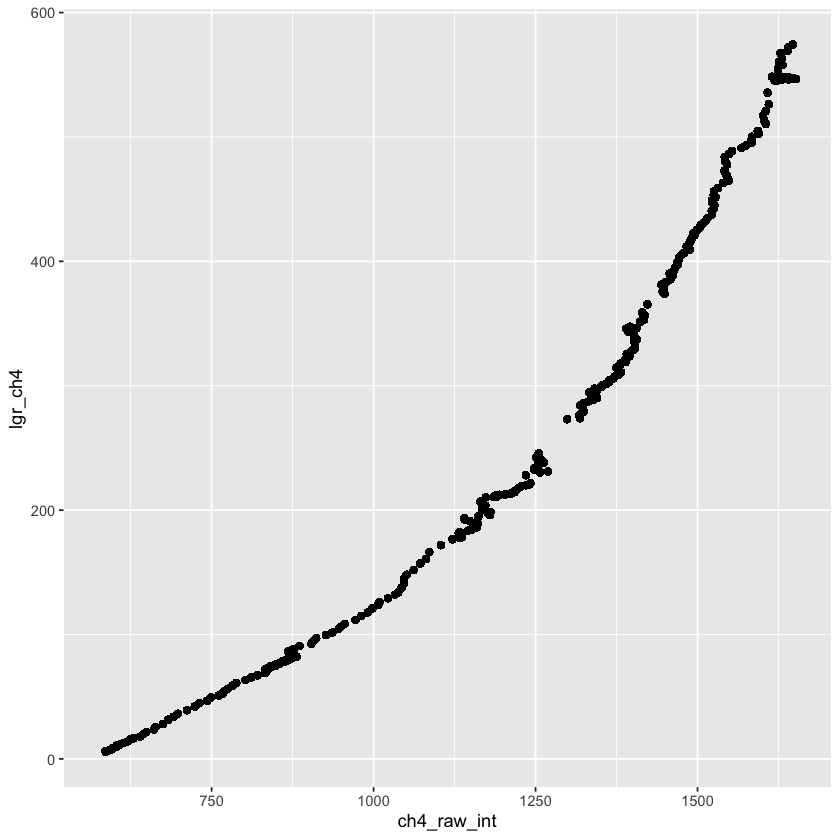

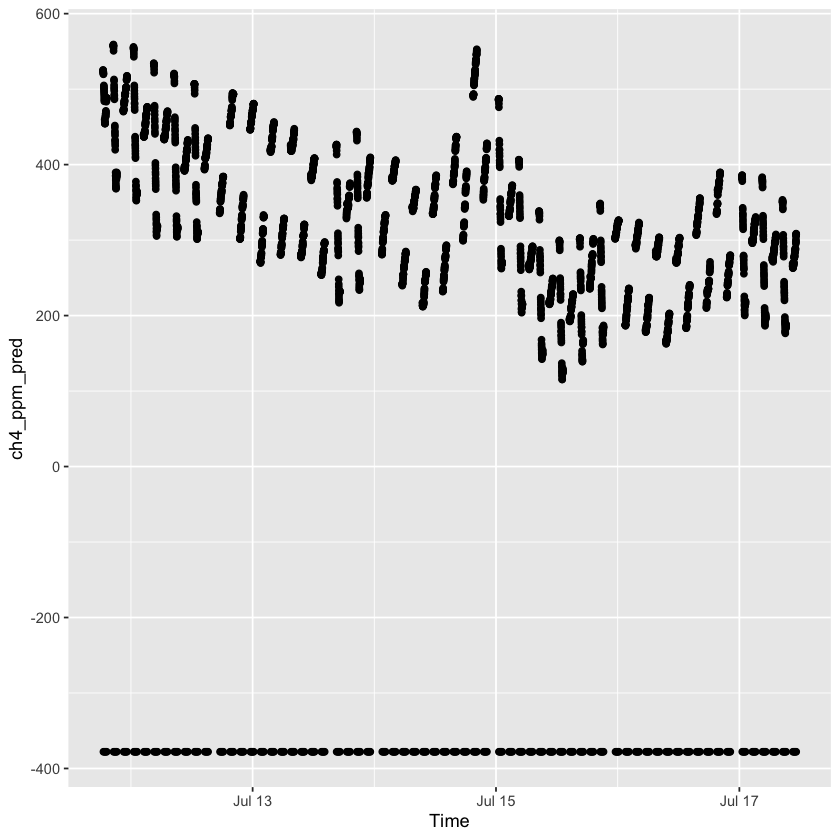

In [16]:
names(b3_exp)
names(assembly_nogap_cal3)
unique(b3_exp$uuid)
unique(assembly_nogap_cal3$uuid)

b3_exp$ch4_raw_log10<-log10(b3_exp$ch4_raw)
assembly_nogap_cal3$ch4_raw<-assembly_nogap_cal3$ch4_raw_int
assembly_nogap_cal3$ch4_raw_log10<-log10(assembly_nogap_cal3$ch4_raw_int)
assembly_nogap_cal3$lgr_ch4_log10<-log10(assembly_nogap_cal3$lgr_ch4)

cal2_ch4_lm<-lm(lgr_ch4_log10~ch4_raw_log10,assembly_nogap_cal3)
summary(cal2_ch4_lm)
cal2_ch4_lm_nolog<-lm(lgr_ch4~ch4_raw,assembly_nogap_cal3)
summary(cal2_ch4_lm_nolog)

b3_exp$ch4_ppm_pred<-predict(cal2_ch4_lm_nolog,newdata=b3_exp)

ggplot(assembly_nogap_cal3,aes(ch4_raw_int,lgr_ch4))+geom_point()
ggplot(b3_exp,aes(Time,ch4_ppm_pred))+geom_point()

In [ ]:
options(warn=-1)
fig <- plot_ly(data = b2_exp, x = ~Time, y = ~ch4_ppm_pred,mode   = 'markers', type   = 'scatter')


fig
options(warn=1)




In [17]:
b3_exp_summary<-subset(b3_exp,type=="raw")
head(b3_exp_summary)

type,site,logger,deployment,deployed_at,uuid,time.s,time.h,battery.V,aht_C,aht_RH,ch4_raw,ch4_cal,user_note,user_value,Time,ch4_raw_log10,ch4_ppm_pred
<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dttm>,<dbl>,<dbl>
raw,PWA,WB3,land_soil-57FF6F068387575149330867-1689089353,1689089353,57FF6F068387575149330867,1689100204,2023-07-11 18:30:18,352,34.94,94.58,1716,0,NA,NA,2023-07-11 18:30:18,3.234517,525.4419
raw,PWA,WB3,land_soil-57FF6F068387575149330867-1689089353,1689089353,57FF6F068387575149330867,1689100234,2023-07-11 18:30:18,360,34.89,94.50,1715,0,NA,NA,2023-07-11 18:30:18,3.234264,524.9155
raw,PWA,WB3,land_soil-57FF6F068387575149330867-1689089353,1689089353,57FF6F068387575149330867,1689100264,2023-07-11 18:31:18,353,34.87,94.55,1714,0,NA,NA,2023-07-11 18:31:18,3.234011,524.3891
raw,PWA,WB3,land_soil-57FF6F068387575149330867-1689089353,1689089353,57FF6F068387575149330867,1689100294,2023-07-11 18:31:19,352,34.85,94.48,1713,0,NA,NA,2023-07-11 18:31:19,3.233757,523.8627
raw,PWA,WB3,land_soil-57FF6F068387575149330867-1689089353,1689089353,57FF6F068387575149330867,1689100324,2023-07-11 18:32:19,358,34.81,94.47,1712,0,NA,NA,2023-07-11 18:32:19,3.233504,523.3363
raw,PWA,WB3,land_soil-57FF6F068387575149330867-1689089353,1689089353,57FF6F068387575149330867,1689100354,2023-07-11 18:32:19,358,34.81,94.45,1711,0,NA,NA,2023-07-11 18:32:19,3.233250,522.8099


[1] 6

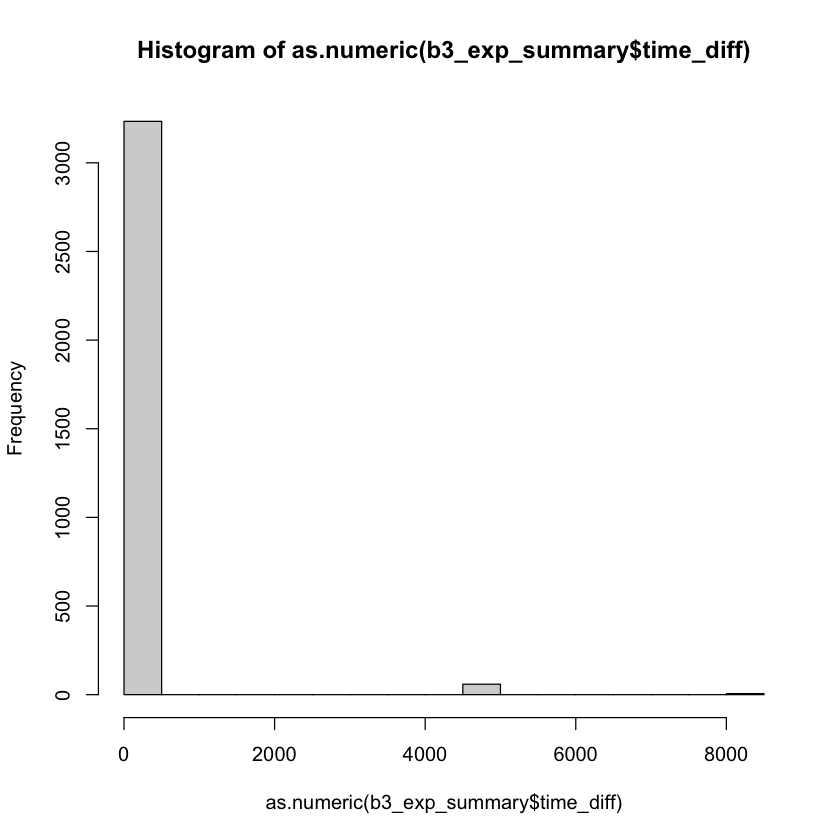

In [18]:
b3_exp_summary$Time_lag<-lag(b3_exp_summary$Time)
b3_exp_summary$time_diff<-as.numeric(b3_exp_summary$Time-b3_exp_summary$Time_lag)
hist(as.numeric(b3_exp_summary$time_diff))
sum(as.numeric(b3_exp_summary$time_diff)>6000,na.rm=TRUE)
#subset(b3_exp_summary,time_diff>2000)

In [20]:

names(b3_exp_summary)
s <- cumsum(c(TRUE,diff(b3_exp_summary$Time)>=2000))
b3_exp_summary$sample_round<-s

[1] "type"          "site"          "logger"        "deployment"   
 [5] "deployed_at"   "uuid"          "time.s"        "time.h"       
 [9] "battery.V"     "aht_C"         "aht_RH"        "ch4_raw"      
[13] "ch4_cal"       "user_note"     "user_value"    "Time"         
[17] "ch4_raw_log10" "ch4_ppm_pred"  "Time_lag"      "time_diff"

In [21]:
slopes_compiled<-data.frame()

for(i in 1:length(unique(b3_exp_summary$sample_round))){
    gas_round<-subset(b3_exp_summary,sample_round==i)    
    slope_ch4<-lm(ch4_ppm_pred~as.numeric(Time),gas_round)
    start_time<-min(gas_round$Time)
    stop_time<-max(gas_round$Time)
    round<-i
    slope<-summary(slope_ch4)$coefficients[2,1]
    deployment<-unique(gas_round$deployment)
    round_slope<-data.frame(start_time=start_time,stop_time=stop_time,round=round,slope=slope)
    slopes_compiled<-bind_rows(slopes_compiled,round_slope)
}
slopes_compiled_b3<-slopes_compiled

In [25]:
slopes_compiled_b3$b_id<-3
saveRDS(slopes_compiled_b3,"slopes_compiled_b3.rds")

[1] "/Users/jdh/SensorDataProcessing/rriv_methane/anya_methane"

In [ ]:

directory1<-paste(datawd,"20230531-cold",sep="") #cold
directory2<-paste(datawd,"20230601",sep="") #room temp 
directory3<-paste(datawd,"20230602-hot",sep="") #"hot"
directory4<-paste(datawd,"20230621-pdock/RRIV/pdock4",sep="") #rriv field data
directory5<-paste(datawd,"20230621-pdock/LGR",sep="") #lgr field data


directory6<-paste(datawd,"20230530Pdock",sep="")#test data 1

dir_wb1<-paste(datawd,"20230717/B1/WB",sep="")
dir_wb2<-paste(datawd,"20230717/B2/WB",sep="")
dir_wb3<-paste(datawd,"20230717/B3/WB",sep="")




In [ ]:
# create output directory path based on input directory
# outputDir<-paste0(directory3,"_output")
outputDir<-paste(datawd,"calibration2_output",sep="")
# create the output directory if necessary
newDir(dirPath = outputDir)

In [ ]:
cal1_20230724<-"/Users/jdh/Library/CloudStorage/GoogleDrive-jakehosen@gmail.com/My Drive/WaterBear/CH4 bucket data/20230724-outside/RRIV/CAL1"
rriv_cal1_20230724<-concat_dirs(cal1_20230724, read_rriv_CSV, filePattern=".CSV", minFileSize=400)
head(rriv_cal1_20230724)
rriv_cal1_20230724<-process_rriv_columns(rriv_cal1_20230724)
rriv_cal1_20230724$Time<-rriv_cal1_20230724$time.h
str(rriv_cal1_20230724)

In [ ]:
# read_rriv_CSV eliminates debug lines and lines where the logger is NA
rriv_data1<-concat_dirs(directory1, read_rriv_CSV, filePattern=".CSV", minFileSize=400)
rriv_data2<-concat_dirs(directory2, read_rriv_CSV, filePattern=".CSV", minFileSize=400)
rriv_data3<-concat_dirs(directory3, read_rriv_CSV, filePattern=".CSV", minFileSize=400)
rriv_data4<-concat_dirs(directory4, read_rriv_CSV, filePattern=".CSV", minFileSize=400)
rriv_data5<-concat_dirs(directory6, read_rriv_CSV, filePattern=".CSV", minFileSize=400)


# process columns to be useful variable types, some columns may need to be done manually
rriv_data1<-process_rriv_columns(rriv_data1)
rriv_data2<-process_rriv_columns(rriv_data2)
rriv_data3<-process_rriv_columns(rriv_data3)
rriv_data4<-process_rriv_columns(rriv_data4)
rriv_data5<-process_rriv_columns(rriv_data5)



# class(rriv_data1)


# str(rriv_data1)
UUIDdict=c(
    "57FF6E068387575148360767"="CAL1",
    "57FF6D068387575151290167"="CAL2",
    "57FF6F068387575149330867"="CAL3",
    "57FF6E068387575140070767"="CAL4",
    "50FF74068678545256252467"="CAL5")
# UUIDdict

rriv_data1<-createSensorColFromIDs(rriv_data1,idCol = "uuid",dict = UUIDdict)
rriv_data2<-createSensorColFromIDs(rriv_data2,idCol = "uuid",dict = UUIDdict)
rriv_data3<-createSensorColFromIDs(rriv_data3,idCol = "uuid",dict = UUIDdict)
rriv_data4<-createSensorColFromIDs(rriv_data4,idCol = "uuid",dict = UUIDdict)
rriv_data5<-createSensorColFromIDs(rriv_data5,idCol = "uuid",dict = UUIDdict)



In [ ]:
lgr_data1<-concat_dirs(directory1, read_GA_ZIP, filePattern=".zip", minFileSize=300)
lgr_data2<-concat_dirs(directory2, read_GA_ZIP, filePattern=".zip", minFileSize=300)
lgr_data3<-concat_dirs(directory3, read_GA_ZIP, filePattern=".zip", minFileSize=300)
lgr_data4<-concat_dirs(directory5, read_GA_ZIP, filePattern=".zip", minFileSize=300)
lgr_data5<-concat_dirs(directory6, read_GA_ZIP, filePattern=".zip", minFileSize=300)

# delete unzipped files
    clean_temp()
# process time column from character
    lgr_data1$Time<-lubridate::as_datetime(lgr_data1$Time)
    lgr_data2$Time<-lubridate::as_datetime(lgr_data2$Time)
    lgr_data3$Time<-lubridate::as_datetime(lgr_data3$Time)
    lgr_data4$Time<-lubridate::as_datetime(lgr_data4$Time)
    lgr_data5$Time<-lubridate::as_datetime(lgr_data5$Time)
    lgr_data_20230724$Time<-lubridate::as_datetime(lgr_data_20230724$Time)


saveDFcsv(lgr_data1)
saveDFcsv(lgr_data2)
saveDFcsv(lgr_data3)
saveDFcsv(lgr_data4)
saveDFcsv(lgr_data5)



In [ ]:
rriv_data1<-rriv_data1[rriv_data1$type=="summary",]
rriv_data2<-as.data.frame(rriv_data2[rriv_data2$type=="summary",])
rriv_data3<-rriv_data3[rriv_data3$type=="summary",]
rriv_data4<-rriv_data4[rriv_data4$type=="summary",]
rriv_data5<-rriv_data5[rriv_data5$type=="summary",]



In [ ]:
ggplot(rriv_data5, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="data 1 ch4 raw")
ggplot(lgr_data5, aes(x=Time, y=X.CH4.d_ppm))+geom_point()+labs(title="data 1 ch4 raw")

In [ ]:
str(rriv_data5)
rriv_data5_df<-as.data.frame(rriv_data5)
#str(lgr_data5)
rriv_data5_df$Time<-rriv_data5_df$time.h
range(lgr_data5$Time)[1]
head(lgr_data5)
#seq(as.POSIXct("2023-05-30 15:02:26 UTC"),as.POSIXct("2023-06-30 15:02:26 UTC"))
#seq(range(rriv_data5_df$Time)[1],range(rriv_data5_df$Time)[2])
#seq(ISOdatetime(2001,2,3,0,0,0), ISOdatetime(2001,2,4,0,0,0), by=(60*5))
assembly_df<-data.frame(Time=as.POSIXct(seq(as.numeric(range(rriv_data5_df$Time)[1]),as.numeric(range(rriv_data5_df$Time)[2]),by=60)))

In [ ]:
rriv_data5_df_cal1<-subset(rriv_data5_df,logger=="CAL1")
rriv_data5_df_cal1$hour<-hour(rriv_data5_df_cal1$Time)
rriv_data5_df_cal1$day<-day(rriv_data5_df_cal1$Time)


rriv_cal1_20230724_int$ch4_raw_int<-approx(rriv_cal1_20230724$Time,rriv_cal1_20230724$ch4_raw,xout=assembly_df$Time)$y
assembly_df$aht_RH_int<-approx(rriv_data5_df_cal1$Time,rriv_data5_df_cal1$aht_RH,xout=assembly_df$Time)$y
assembly_df$aht_C_int<-approx(rriv_data5_df_cal1$Time,rriv_data5_df_cal1$aht_C,xout=assembly_df$Time)$y



assembly_df$ch4_raw_int<-approx(rriv_data5_df_cal1$Time,rriv_data5_df_cal1$ch4_raw,xout=assembly_df$Time)$y
assembly_df$aht_RH_int<-approx(rriv_data5_df_cal1$Time,rriv_data5_df_cal1$aht_RH,xout=assembly_df$Time)$y
assembly_df$aht_C_int<-approx(rriv_data5_df_cal1$Time,rriv_data5_df_cal1$aht_C,xout=assembly_df$Time)$y
assembly_df$lgr_ch4<-approx(lgr_data5$Time,lgr_data5$X.CH4._ppm,xout=assembly_df$Time)$y
assembly_df$hour<-hour(assembly_df$Time)
assembly_df$day<-day(assembly_df$Time)


assembly_nogap<-merge(assembly_df,rriv_data5_df_cal1[,c("hour","day")],by=c("hour","day"))

In [ ]:
head(lgr_data_20230724)

In [ ]:
#assembly new data
assembly_df_20230724_int<-data.frame(Time=as.POSIXct(seq(as.numeric(range(rriv_cal1_20230724$Time)[1]),as.numeric(range(rriv_cal1_20230724$Time)[2]),by=60)))

assembly_df_20230724_int$ch4_raw_int<-approx(rriv_cal1_20230724$Time,rriv_cal1_20230724$ch4_raw,xout=assembly_df_20230724_int$Time)$y
assembly_df_20230724_int$aht_RH_int<-approx(rriv_cal1_20230724$Time,rriv_cal1_20230724$aht_RH,xout=assembly_df_20230724_int$Time)$y
assembly_df_20230724_int$aht_C_int<-approx(rriv_cal1_20230724$Time,rriv_cal1_20230724$aht_C,xout=assembly_df_20230724_int$Time)$y

assembly_df_20230724_int$lgr_ch4<-approx(lgr_data_20230724$Time,lgr_data_20230724$X.CH4._ppm,xout=assembly_df_20230724_int$Time)$y

assembly_df_20230724_int$ch4_predict_lm<-10^predict(cal1_lm,newdata=assembly_df_20230724_int)


tail(assembly_df_20230724_int,n=100)

ggplot(assembly_df_20230724_int,aes(lgr_ch4,ch4_predict_lm))+
geom_point()



In [ ]:
head(assembly_nogap)

ggplot(assembly_nogap,aes(ch4_raw_int,lgr_ch4))+
geom_point()

cal1_lm<-lm(log10(lgr_ch4)~log10(ch4_raw_int)+aht_RH_int+aht_C_int,data=assembly_nogap)
summary(cal1_lm)



In [ ]:
head(assembly_nogap)

In [ ]:
assembly_nogap$ch4_predict_lm<-10^predict(cal1_lm,newdata=assembly_nogap)
head(assembly_nogap)
data.frame(Time=rriv_cal1_20230724$Time,ch4_raw_int=rriv_cal1_20230724

rriv_cal1_20230724_int$ch4_predict_lm<-10^predict(cal1_lm,newdata=rriv_cal1_20230724_int)

In [ ]:
head(assembly_nogap)

## interpolate

In [ ]:
# Manually create dictionary for column names, and what to rename them to in output df
interpolateDict<-c(
        "ch4_raw"="ch4_raw_rriv",
        "aht_C"="aht_C",
        "aht_RH"="aht_RH",
        "dht_C"="dht_C",
        "dht_RH"="dht_RH",
        "X.CH4._ppm"="ch4_ppm_lgr")

In [ ]:
interpolateData<-function(df1=rriv_data_overlap, df1TimeCol="time.h",
                          df2=lgr_data_overlap, df2TimeCol="Time",
                          iDict=interpolateDict){
    iD<-iDict
    iKeys<-names(iD)
    
    # extract time range for first data frame
    df1r<-range(df1[[ df1TimeCol ]])

    # extract time range for second data frame
    df2r<-range(df2[[ df2TimeCol ]])

    # create output dataframe using whichever time range is larger
    # use sequence to create minute intervals across the range for data points in a new dataframe
    if(df1r[2]-df1r[1] > df2r[2]-df2r[1]){
        print("df1 time range is larger")
        outputDF<-data.frame(time_utc=seq(df1r[1],df1r[2], by="min"))
    } else{
        print("df2 time range is larger")
        outputDF<-data.frame(time_utc=seq(df2r[1],df2r[2], by="min"))
    }
    
    # extract column names from dataframe 1
    cols<-names(df1)

    # only interpolate data that is both in the dictionary and in the column names
    for(key in iKeys[iKeys %in% cols]){
        outputDF[[ iD[[key]] ]]<-approx(df1[[df1TimeCol]], df1[[key]], outputDF[["time_utc"]])$y
    }

    # extract column names from dataframe 2
    cols<-names(df2)

    # only interpolate data that is both in the dictionary and in the column names
    for(key in iKeys[iKeys %in% cols]){
        outputDF[[ iD[[key]] ]]<-approx(df2[[df2TimeCol]], df2[[key]], outputDF[["time_utc"]])$y
    }

    # remove lines with NA
    outputDF<-outputDF[complete.cases(outputDF),]
    
    return(outputDF)
}

In [ ]:
# interpolate data for each uuid then merge via rbind()
#should be for summary values? 
sensorList<-unique(rriv_data1$Sensor)
sensorList

#data1
interpolated1<-data.frame()
for(sensor in sensorList){
    subset<-rriv_data1[rriv_data1$Sensor==sensor,]
    temp<-interpolateData(df1=subset,df2=lgr_data1)
    temp$Sensor=sensor
    interpolated1<-rbind(interpolated1, temp)
}
# interpolated1
# data2
# rriv_data2
interpolated2<-data.frame()
for(sensor in sensorList){
    subset<-rriv_data2[rriv_data2$Sensor==sensor,]
    temp<-interpolateData(df1=subset,df2=lgr_data2)
    temp$Sensor=sensor
    interpolated2<-rbind(interpolated2, temp)
}
#data3
sensorList<-unique(rriv_data3$Sensor)
interpolated3<-data.frame()
for(sensor in sensorList){
    subset<-rriv_data3[rriv_data3$Sensor==sensor,]
    temp<-interpolateData(df1=subset,df2=lgr_data3)
    temp$Sensor=sensor
    interpolated3<-rbind(interpolated3, temp)
}


# data4
# error if only 1 sensor
sensorList<-unique(rriv_data4$Sensor)

tempList<-vector(mode = "list",length = length(sensorList))
names(tempList)<-sensorList

interpolated4<-data.frame()
for(sensor in sensorList){
    subset<-rriv_data4[rriv_data4$Sensor==sensor,]
    
    tempList[[ sensor ]]<-interpolateData(df1=subset,df2=lgr_data4)
    tempList[[ sensor ]]$Sensor=sensor
    # temp<-interpolateData(df1=subset,df2=lgr_data5_overlap)
    # temp$Sensor=sensor
    # interpolated_data5<-rbind(interpolated_data5, temp)
}
output<-(tempList)
interpolated4<-(output[[ sensorList[1] ]])
# interpolated4


# #data5
sensorList<-unique(rriv_data5$Sensor)
interpolated5<-data.frame()
for(sensor in sensorList){
    subset<-rriv_data5[rriv_data5$Sensor==sensor,]
    temp<-interpolateData(df1=subset,df2=lgr_data5)
    temp$Sensor=sensor
    interpolated5<-rbind(interpolated5, temp)
}

In [ ]:
# ggplot(interpolated5, aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data 1 ch4 raw")
# ggplot(lgr_data5, aes(x=Time, y=X.CH4.d_ppm))+geom_point()+labs(title="data 1 ch4 raw")

# align & clean

In [ ]:

ts1<-lubridate::as_datetime("2023-05-31 14:52:51.458")
ts2<-lubridate::as_datetime("2023-05-31 15:58:51.06")
interpolated1<-interpolated1[interpolated1$time_utc>ts1 & interpolated1$time_utc<ts2,]
lgr_data1<-lgr_data1[lgr_data1$Time>ts1 & lgr_data1$Time<ts2,]

# ggplot(interpolated1, aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data 1 ch4 raw")
# ggplot(lgr_data1, aes(x=Time, y=X.CH4.d_ppm))+geom_point()+labs(title="data 1 ch4 raw")

In [ ]:
ts1<-lubridate::as_datetime("2023-06-01 16:23:28.785")
ts2<-lubridate::as_datetime("2023-06-01 17:46:23.751")
ts3<-lubridate::as_datetime("2023-06-01 17:49:46.757")
ts4<-lubridate::as_datetime("2023-06-01 19:29:36.958")
rriv1<-interpolated2[interpolated2$time_utc>ts1 & interpolated2$time_utc<ts2,]
rriv2<-interpolated2[interpolated2$time_utc>ts3 & interpolated2$time_utc<ts4,]
lgr1<-lgr_data2[lgr_data2$Time>ts1 & lgr_data2$Time<ts2,]
lgr2<-lgr_data2[lgr_data2$Time>ts3 & lgr_data2$Time<ts4,]
interpolated2<-rbind(rriv1,rriv2)
lgr_data2<-rbind(lgr1,lgr2)
# ggplot(interpolated2, aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data 1 ch4 raw")
# ggplot(lgr_data2, aes(x=Time, y=X.CH4.d_ppm))+geom_point()+labs(title="data 1 ch4 raw")

In [ ]:

ts1<-lubridate::as_datetime("2023-06-02 14:59:18.373")
ts2<-lubridate::as_datetime("2023-06-02 16:39:08.562")
interpolated3<-interpolated3[interpolated3$time_utc>ts1 & interpolated3$time_utc<ts2,]
lgr_data3<-lgr_data3[lgr_data3$Time>ts1 & lgr_data3$Time<ts2,]

# ggplot(interpolated3, aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data 1 ch4 raw")
# ggplot(lgr_data3, aes(x=Time, y=X.CH4.d_ppm))+geom_point()+labs(title="data 1 ch4 raw")


In [ ]:

ts1<-lubridate::as_datetime("2023-06-21 16:00:03.755")
ts2<-lubridate::as_datetime("2023-06-21 18:10:31.562")
interpolated4<-interpolated4[interpolated4$time_utc>ts1 & interpolated4$time_utc<ts2,]
lgr_data4<-lgr_data4[lgr_data4$Time>ts1 & lgr_data4$Time<ts2,]
# ggplot(interpolated4, aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data 1 ch4 raw")
# ggplot(lgr_data4, aes(x=Time, y=X.CH4.d_ppm))+geom_point()+labs(title="data 1 ch4 raw")


In [ ]:
ts1<-lubridate::as_datetime("2023-05-30 15:09:12.167")
ts2<-lubridate::as_datetime("2023-05-30 15:31:12.061")
ts3<-lubridate::as_datetime("2023-05-30 15:34:35.158")
ts4<-lubridate::as_datetime("2023-05-30 16:15:11.862")
rriv1<-interpolated5[interpolated5$time_utc>ts1 & interpolated5$time_utc<ts2,]
rriv2<-interpolated5[interpolated5$time_utc>ts3 & interpolated5$time_utc<ts4,]
lgr1<-lgr_data5[lgr_data5$Time>ts1 & lgr_data5$Time<ts2,]
lgr2<-lgr_data5[lgr_data5$Time>ts3 & lgr_data5$Time<ts4,]
interpolated5<-rbind(rriv1,rriv2)
lgr_data5<-rbind(lgr1,lgr2)
# ggplot(interpolated5, aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data 1 ch4 raw")
# ggplot(lgr_data5, aes(x=Time, y=X.CH4.d_ppm))+geom_point()+labs(title="data 1 ch4 raw")

In [ ]:
#don't include data group 5 
all_interpolated1<-rbind(interpolated1,interpolated2,interpolated3,interpolated4)

# GAM

## build Gams 

### Gam1 

In [ ]:
# #curently not used 
# Calculate sensor resistance(Rs) using Figaro(manufacturer) equation
# # Rs = (VC/VRL-1)*RL where
# # VC = circuit voltage
# # VRL = output voltage
# # RL = load resistance
# # 3-code 272 = 2.7kohm
# RL = 2.7*1000  #convert kOhm to Ohm
# VC = 5

# # convert digital signal to voltage
# interpolated_data$ch4_V=5/4096*interpolated_data$ch4_raw_rriv

# # calculate sensor resistance (Rs)
# interpolated_data$Rs_fig<-(VC/interpolated_data$ch4_V-1)*RL

# # calculate absolute humidity from celsius and relative humidity
# interpolated_data<-calcAbsoluteHumidity(interpolated_data,celsius = "aht_C",relativeHumidity = "aht_RH")

# # head(interpolated_data)

In [ ]:
interpolated1_cal1<-all_interpolated1[all_interpolated1$Sensor=="CAL1",]
interpolated1_cal2<-all_interpolated1[all_interpolated1$Sensor=="CAL2",]
interpolated1_cal3<-all_interpolated1[all_interpolated1$Sensor=="CAL3",]
interpolated1_cal4<-all_interpolated1[all_interpolated1$Sensor=="CAL4",]
interpolated1_cal5<-all_interpolated1[all_interpolated1$Sensor=="CAL5",]

gam1_rriv1<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=interpolated1_cal1)
gam1_rriv2<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=interpolated1_cal2)
gam1_rriv3<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=interpolated1_cal3)
gam1_rriv4<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=interpolated1_cal4)
gam1_rriv5<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=interpolated1_cal5)

summary(gam1_rriv1)
# summary(gam_rriv2)
# summary(gam_rriv3)
# summary(gam_rriv4)
# summary(gam_rriv5)


In [ ]:
predict(gam1_rriv1)->interpolated1_cal1$predict_ch4
predict(gam1_rriv2)->interpolated1_cal2$predict_ch4
predict(gam1_rriv3)->interpolated1_cal3$predict_ch4
predict(gam1_rriv4)->interpolated1_cal4$predict_ch4
predict(gam1_rriv5)->interpolated1_cal5$predict_ch4
all_interpolated1<-rbind(interpolated1_cal1,interpolated1_cal2,interpolated1_cal3,interpolated1_cal4,interpolated1_cal5)

In [ ]:
a<-ggplot(all_interpolated1,aes(x=ch4_ppm_lgr,y=predict_ch4,color=Sensor))+geom_point(size=5,alpha=0.25)+
    geom_abline(slope = 1, linewidth=2)+geom_smooth(method="gam")+
    theme_classic()+theme(panel.background = element_rect(fill = "#E3E3E3"))+
    labs(title="LGR CH4 vs RRIV CH4 Model",x="LGR CH4 (ppm)",y="RRIV CH4 predicted (ppm)")+
    theme(axis.text = element_text(size = 40,face="bold"), 
        axis.title = element_text(size = 40,face="bold"),
        plot.title = element_text(size = 50, face = "bold"),
        legend.title = element_text(color = "black", size = 30,face="bold"),
        legend.text = element_text(color = "black", size = 30,face="bold")
     )
a    
savePlot(a,width=900,height=900)

### GAM2: no cold


In [ ]:
all_interpolated2<-rbind(interpolated2,interpolated3,interpolated4)

interpolated2_cal1<-all_interpolated[all_interpolated2$Sensor=="CAL1",]
interpolated2_cal2<-all_interpolated[all_interpolated2$Sensor=="CAL2",]
interpolated2_cal3<-all_interpolated[all_interpolated2$Sensor=="CAL3",]
interpolated2_cal4<-all_interpolated[all_interpolated2$Sensor=="CAL4",]
interpolated2_cal5<-all_interpolated[all_interpolated2$Sensor=="CAL5",]

gam2_rriv1<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=interpolated2_cal1)
gam2_rriv2<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=interpolated2_cal2)
gam2_rriv3<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=interpolated2_cal3)
gam2_rriv4<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=interpolated2_cal4)
gam2_rriv5<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=interpolated2_cal5)
summary(gam2_rriv1)

In [ ]:
predict(gam2_rriv1)->interpolated2_cal1$predict_ch4
predict(gam2_rriv2)->interpolated2_cal2$predict_ch4
predict(gam2_rriv3)->interpolated2_cal3$predict_ch4
predict(gam2_rriv4)->interpolated2_cal4$predict_ch4
predict(gam2_rriv5)->interpolated2_cal5$predict_ch4
all_interpolated2<-rbind(interpolated2_cal1,interpolated2_cal2,interpolated2_cal3,interpolated2_cal4,interpolated2_cal5)

In [ ]:
b<-ggplot(all_interpolated2,aes(x=ch4_ppm_lgr,y=predict_ch4,color=Sensor))+geom_point(size=5,alpha=0.25)+
    geom_abline(slope = 1, linewidth=2)+geom_smooth(method="gam")+
    theme_classic()+theme(panel.background = element_rect(fill = "#E3E3E3"))+
    labs(title="LGR CH4 vs RRIV CH4 Model",x="LGR CH4 (ppm)",y="RRIV CH4 predicted (ppm)")+
    theme(axis.text = element_text(size = 40,face="bold"), 
        axis.title = element_text(size = 40,face="bold"),
        plot.title = element_text(size = 50, face = "bold"),
        legend.title = element_text(color = "black", size = 30,face="bold"),
        legend.text = element_text(color = "black", size = 30,face="bold")
     )
b    
savePlot(b,width=900,height=900)

### gam3 : only other field data

In [ ]:
# interpolated1_cal1<-all_interpolated1[all_interpolated1$Sensor=="CAL1",]
# interpolated1_cal2<-all_interpolated1[all_interpolated1$Sensor=="CAL2",]
# interpolated1_cal3<-all_interpolated1[all_interpolated1$Sensor=="CAL3",]
# interpolated1_cal4<-all_interpolated1[all_interpolated1$Sensor=="CAL4",]
# interpolated1_cal5<-all_interpolated1[all_interpolated1$Sensor=="CAL5",]

# gam1_rriv1<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=interpolated1_cal1)
# gam1_rriv2<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=interpolated1_cal2)
# gam1_rriv3<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=interpolated1_cal3)
# gam1_rriv4<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=interpolated1_cal4)
# gam1_rriv5<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=interpolated1_cal5)

# summary(gam1_rriv1)
# # summary(gam_rriv2)
# # summary(gam_rriv3)
# # summary(gam_rriv4)
# # summary(gam_rriv5)


## test gams 

### GAM1

In [ ]:
# interpolated 5 is test data 
test_data5_cal1<-interpolated5[interpolated5$Sensor=="CAL1",]
test_data5_cal2<-interpolated5[interpolated5$Sensor=="CAL2",]
test_data5_cal3<-interpolated5[interpolated5$Sensor=="CAL3",]
test_data5_cal4<-interpolated5[interpolated5$Sensor=="CAL4",]
test_data5_cal5<-interpolated5[interpolated5$Sensor=="CAL5",]

In [ ]:

predict(gam1_rriv1,test_data5_cal1)->test_data5_cal1$predict_ch4
predict(gam1_rriv2,test_data5_cal2)->test_data5_cal2$predict_ch4
predict(gam1_rriv3,test_data5_cal3)->test_data5_cal3$predict_ch4
predict(gam1_rriv4,test_data5_cal4)->test_data5_cal4$predict_ch4
predict(gam1_rriv5,test_data5_cal5)->test_data5_cal5$predict_ch4

gam1_predict_data5<-rbind(test_data5_cal1,test_data5_cal2,test_data5_cal3,test_data5_cal4,test_data5_cal5)


In [ ]:
#raw
# ggplot(rriv_data5, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="data 1 ch4 raw")
ggplot(lgr_data5, aes(x=Time, y=X.CH4.d_ppm))+geom_point()+labs(title="data 1 ch4 raw")
ggplot(interpolated5, aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data 1 ch4 raw")
# ggplot(lgr_data5, aes(x=Time, y=X.CH4.d_ppm))+geom_point()+labs(title="data 1 ch4 raw")

#predicted
# ggplot(test_data5_cal3,aes(x=time_utc,y=predict_ch4))+geom_point(size=5,color="blue")
ggplot(gam1_predict_data5,aes(x=time_utc,y=predict_ch4,color=Sensor))+geom_point(size=5)


In [ ]:
# interpolated 5 is test data 
test_data5_cal1<-interpolated3[interpolated5$Sensor=="CAL1",]
test_data5_cal2<-interpolated3[interpolated5$Sensor=="CAL2",]
test_data5_cal3<-interpolated3[interpolated3$Sensor=="CAL3",]
test_data5_cal4<-interpolated3[interpolated3$Sensor=="CAL4",]
test_data5_cal5<-interpolated3[interpolated3$Sensor=="CAL5",]

In [ ]:

predict(gam1_rriv1,test_data3_cal1)->test_data3_cal1$predict_ch4
predict(gam1_rriv2,test_data3_cal2)->test_data3_cal2$predict_ch4
predict(gam1_rriv3,test_data3_cal3)->test_data3_cal3$predict_ch4
predict(gam1_rriv4,test_data3_cal4)->test_data3_cal4$predict_ch4
predict(gam1_rriv5,test_data3_cal5)->test_data3_cal5$predict_ch4

gam1_predict_data3<-rbind(test_data3_cal1,test_data3_cal2,test_data3_cal3,test_data3_cal4,test_data3_cal5)


In [ ]:
#raw
# ggplot(rriv_data5, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="data 1 ch4 raw")
ggplot(lgr_data3, aes(x=Time, y=X.CH4.d_ppm))+geom_point()+labs(title="data 1 ch4 raw")
ggplot(interpolated3, aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data 1 ch4 raw")
# ggplot(lgr_data5, aes(x=Time, y=X.CH4.d_ppm))+geom_point()+labs(title="data 1 ch4 raw")

#predicted
ggplot(gam1_predict_data3,aes(x=time_utc,y=predict_ch4,color=Sensor))+geom_point(size=5)

### GAM2

In [ ]:
# interpolated 3 is test data 
test2_data3_cal1<-interpolated3[interpolated3$Sensor=="CAL1",]
test2_data3_cal2<-interpolated3[interpolated3$Sensor=="CAL2",]
test2_data3_cal3<-interpolated3[interpolated3$Sensor=="CAL3",]
test2_data3_cal4<-interpolated3[interpolated3$Sensor=="CAL4",]
test2_data3_cal5<-interpolated3[interpolated3$Sensor=="CAL5",]

In [ ]:

predict(gam2_rriv1,test2_data3_cal1)->test2_data3_cal1$predict_ch4
predict(gam2_rriv2,test2_data3_cal2)->test2_data3_cal2$predict_ch4
predict(gam2_rriv3,test2_data3_cal3)->test2_data3_cal3$predict_ch4
predict(gam2_rriv4,test2_data3_cal4)->test2_data3_cal4$predict_ch4
predict(gam2_rriv5,test2_data3_cal5)->test2_data3_cal5$predict_ch4

gam2_predict_data3<-rbind(test2_data3_cal1,test2_data3_cal2,test2_data3_cal3,test2_data3_cal4,test2_data3_cal5)


In [ ]:
#raw
# ggplot(rriv_data5, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="data 1 ch4 raw")
ggplot(lgr_data3, aes(x=Time, y=X.CH4.d_ppm))+geom_point()+labs(title="data 1 ch4 raw")
ggplot(interpolated3, aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data 1 ch4 raw")
# ggplot(lgr_data5, aes(x=Time, y=X.CH4.d_ppm))+geom_point()+labs(title="data 1 ch4 raw")

#predicted
# ggplot(test2_data3_cal5,aes(x=time_utc,y=predict_ch4))+geom_point(size=5,color="blue")
ggplot(gam2_predict_data3,aes(x=time_utc,y=predict_ch4,color=Sensor))+geom_point(size=5)

In [ ]:
# interpolated 5 is test data 
test2_data5_cal1<-interpolated5[interpolated5$Sensor=="CAL1",]
test2_data5_cal2<-interpolated5[interpolated5$Sensor=="CAL2",]
test2_data5_cal3<-interpolated5[interpolated5$Sensor=="CAL3",]
test2_data5_cal4<-interpolated5[interpolated5$Sensor=="CAL4",]
test2_data5_cal5<-interpolated5[interpolated5$Sensor=="CAL5",]

In [ ]:

predict(gam2_rriv1,test2_data5_cal1)->test2_data5_cal1$predict_ch4
predict(gam2_rriv2,test2_data5_cal2)->test2_data5_cal2$predict_ch4
predict(gam2_rriv3,test2_data5_cal3)->test2_data5_cal3$predict_ch4
predict(gam2_rriv4,test2_data5_cal4)->test2_data5_cal4$predict_ch4
predict(gam2_rriv5,test2_data5_cal5)->test2_data5_cal5$predict_ch4

gam2_predict_data5<-rbind(test2_data5_cal1,test2_data5_cal2,test2_data5_cal3,test2_data5_cal4,test2_data5_cal5)


In [ ]:
#raw
# ggplot(rriv_data5, aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()+labs(title="data 1 ch4 raw")
ggplot(lgr_data5, aes(x=Time, y=X.CH4.d_ppm))+geom_point()+labs(title="data 1 ch4 raw")
ggplot(interpolated5, aes(x=time_utc, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data 1 ch4 raw")
# ggplot(lgr_data5, aes(x=Time, y=X.CH4.d_ppm))+geom_point()+labs(title="data 1 ch4 raw")

#predicted
# ggplot(test2_data5_cal5,aes(x=time_utc,y=predict_ch4))+geom_point(size=5,color="blue")
ggplot(gam2_predict_data5,aes(x=time_utc,y=predict_ch4,color=Sensor))+geom_point(size=5)

# test field data 3 day

## setup

In [ ]:
# dictionary of UUIDS to sensorIDs
UUIDdict2=c(
    "57FF6E068387575148360767"="WB1",
    "50FF6D068678545249232467"="WB2",
    "57FF6F068387575149330867"="WB3"#,
    # "57FF6B068387575150310767"="AP1",
    # "57FF6E068387575140070767"="AP2",
    # "50FF74068678545256252467"="AP3",
    # "57FF6A068387575136311367"="S1"
)


In [ ]:
#read wb 
data_wb1<-concat_dirs(dir_wb1, read_rriv_CSV, filePattern=".CSV", minFileSize=400)
data_wb1<-process_rriv_columns(data_wb1)
# saveDFcsv(data_wb1)
data_wb1<-createSensorColFromIDs(data_wb1,idCol = "uuid",dict = UUIDdict2)

data_wb2<-concat_dirs(dir_wb2, read_rriv_CSV, filePattern=".CSV", minFileSize=400)
data_wb2<-process_rriv_columns(data_wb2)
# saveDFcsv(data_wb2)
data_wb2<-createSensorColFromIDs(data_wb2,idCol = "uuid",dict = UUIDdict2)

data_wb3<-concat_dirs(dir_wb3, read_rriv_CSV, filePattern=".CSV", minFileSize=400)
data_wb3<-process_rriv_columns(data_wb3)
# saveDFcsv(data_wb3)
data_wb3<-createSensorColFromIDs(data_wb3,idCol = "uuid",dict = UUIDdict2)

data_all<-as.data.frame(rbind(data_wb1,data_wb2,data_wb3))
# data_all

In [ ]:
# convert time.s to better timestamp.
data_all$time.h<-lubridate::as_datetime(data_all$time.s)
# copy_all$time.h
# copy_all

In [ ]:
# average every 10 data points to get your "summary" value
#temp and ch4
sum_ch4<-0
sum_temp<-0
count<-0
for(i in 1:nrow(data_all)) {
# for(i in 1:22) {
    if(data_all[i,]$type=="raw"){
        sum_ch4<-sum_ch4+data_all[i,12]
        sum_temp<-sum_temp+data_all[i,10]
        count<-count+1
        # print(paste("sum ch4: ", sum_ch4)) 
        # print(paste("sum temp: ", sum_temp))
        # print(paste("count: ", count)) 
    }
    if(data_all[i,]$type=="summary"){
        data_all[i,12]<-sum_ch4/count
        data_all[i,10]<-sum_temp/count
        # print(paste("summary ch4: ", copy_all[i,12]))
        # print(paste("summary temp: ", copy_all[i,10]))
        sum_ch4<-0
        sum_temp<-0
        count<-0
    }
}
data_all<-data_all[data_all$type=="summary",]

In [ ]:
# data_all
names(data_all)[12] <- "ch4_raw_rriv"
# data_all

In [ ]:
#cut out data at end when submerged 
ts1<-1689112414.374
ts2<-1689399003.047
clean_all<-data_all[data_all$time.s>ts1 & data_all$time.s<ts2,]


## GAM1

In [ ]:
# interpolated 3 is test data
gam1_data_all<-clean_all
test1_data_all_wb1<-gam1_data_all[gam1_data_all$Sensor=="WB1",]
test1_data_all_wb2<-gam1_data_all[gam1_data_all$Sensor=="WB2",]
test1_data_all_wb3<-gam1_data_all[gam1_data_all$Sensor=="WB3",]


In [ ]:

predict(gam1_rriv1,test1_data_all_wb1)->test1_data_all_wb1$predict_ch4
predict(gam1_rriv2,test1_data_all_wb2)->test1_data_all_wb2$predict_ch4
predict(gam1_rriv3,test1_data_all_wb3)->test1_data_all_wb3$predict_ch4

gam1_data_all<-rbind(test1_data_all_wb1,test1_data_all_wb2,test1_data_all_wb3)
# gam1_data_all

In [ ]:
# gam1_data_all
#raw
ggplot(gam1_data_all, aes(x=time.h, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data 1 ch4 raw")

#predicted
ggplot(gam1_data_all,aes(x=time.h,y=predict_ch4,color=Sensor))+geom_point(size=5)

## GAM2

In [ ]:
# interpolated 3 is test data
gam2_data_all<-clean_all
test2_data_all_wb1<-gam2_data_all[gam2_data_all$Sensor=="WB1",]
test2_data_all_wb2<-gam2_data_all[gam2_data_all$Sensor=="WB2",]
test2_data_all_wb3<-gam2_data_all[gam2_data_all$Sensor=="WB3",]


In [ ]:

predict(gam2_rriv1,test2_data_all_wb1)->test2_data_all_wb1$predict_ch4
predict(gam2_rriv2,test2_data_all_wb2)->test2_data_all_wb2$predict_ch4
predict(gam2_rriv3,test2_data_all_wb3)->test2_data_all_wb3$predict_ch4

gam2_data_all<-rbind(test2_data_all_wb1,test2_data_all_wb2,test2_data_all_wb3)
# gam1_data_all

In [ ]:
# gam1_data_all
#raw
ggplot(gam2_data_all, aes(x=time.h, y=ch4_raw_rriv, color=Sensor))+geom_point()+labs(title="data 1 ch4 raw")

#predicted
ggplot(gam2_data_all,aes(x=time.h,y=predict_ch4,color=Sensor))+geom_point(size=5)